**Scenario A**

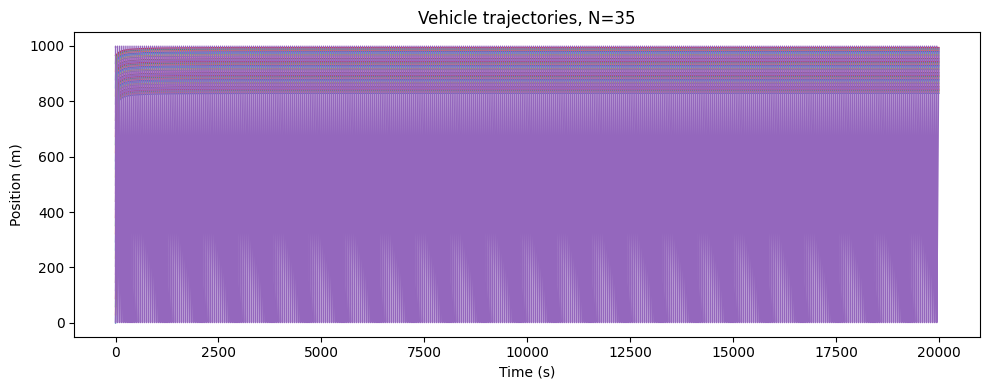

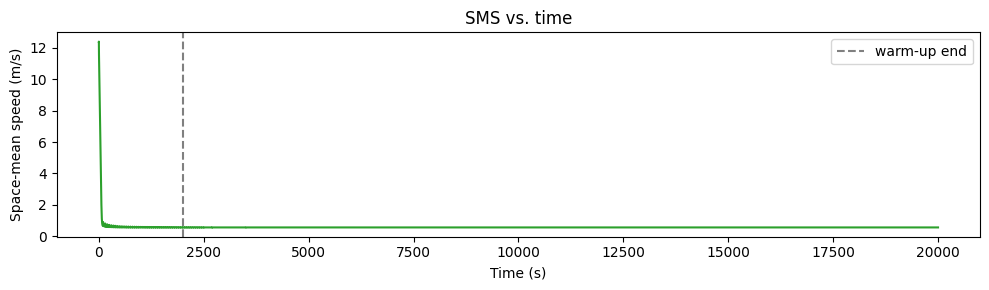

Steady SMS ≈ 0.57 m/s, density = 0.035 veh/m, flow ≈ 0.020 veh/s


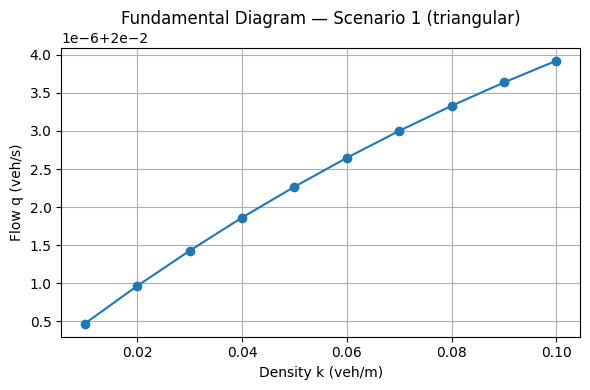

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Model parameters (gap τ=2 s, L=5 m, Δt=0.1 s) from the assignment :contentReference[oaicite:0]{index=0}
tau       = 2.0
L_vehicle = 5.0
dt        = 0.1
v_f       = 20.0

L_road   = 1000.0
T_total  = 20000.0
warmup   = 2000.0

def simulate(N, T=T_total):
    n_steps = int(T / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    v = np.zeros(N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)
    
    for t in range(n_steps):
        traj[t] = x.copy()
        x_next = np.roll(x, -1)
        gaps = np.maximum(x_next - x - L_vehicle, 0.0)
        #gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        v      = np.minimum(gaps / tau, v_f)
        x      = (x + v * dt) % L_road
        SMS[t] = v.mean()
    
    return traj, SMS

def main():
    # ——— Prompt for N0 and validate ———
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            else:
                print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")
    
    # ——— Run simulation for that N0 ———
    traj, SMS = simulate(N0)
    times = np.arange(len(SMS)) * dt

    # a) Trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Vehicle trajectories, N={N0}')
    plt.tight_layout()
    plt.show()

    # b) SMS vs. time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, color='tab:green')
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute steady‑state SMS and flow
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road
    flow0        = density0 * steady_sms
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # ——— Fundamental diagram sweep (densities → flows) ———
    densities = np.linspace(0.01, 0.1, 10)
    flows      = []
    for k in densities:
        N = max(2, int(k * L_road))
        # ensure we never exceed 120 vehicles
        N = min(N, 120)
        _, SMS_k = simulate(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows.append(k * steady_sms_k)

    plt.figure(figsize=(6, 4))
    plt.plot(densities, flows, 'o-', color='tab:blue')
    plt.xlabel('Density k (veh/m)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Fundamental Diagram — Scenario 1 (triangular)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


**Scenario B**

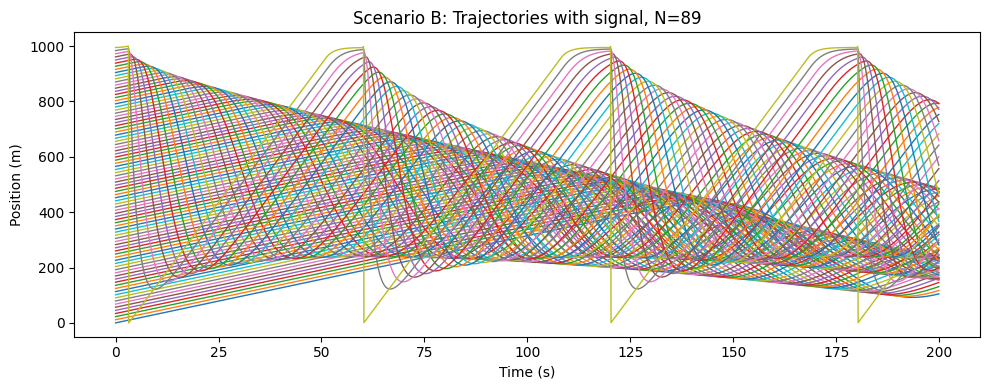

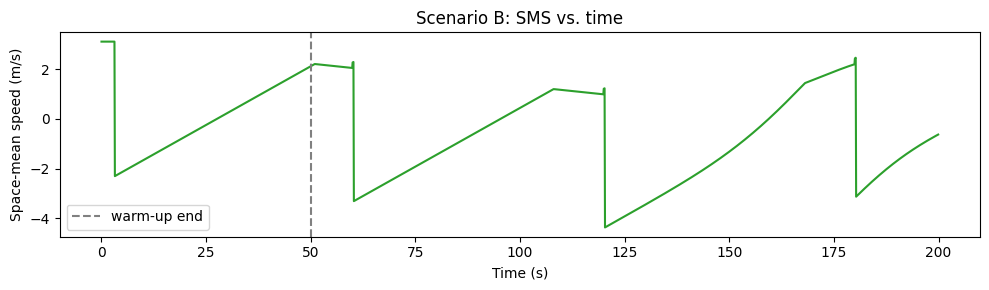

Steady SMS ≈ -0.76 m/s, density = 0.089 veh/m, flow ≈ -0.068 veh/s


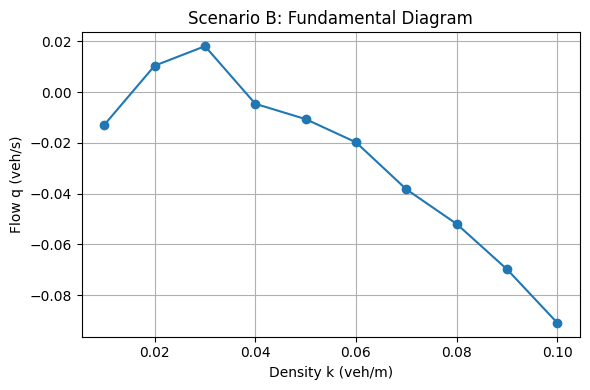

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model parameters (from §B) ---
tau       = 2.0    # desired time gap (s)
L_vehicle = 5.0    # vehicle length (m)
dt        = 0.1    # time step (s)
v_f       = 20.0   # free‑flow speed (m/s)

# --- Road & signal settings ---
L_road   = 1000.0  # ring length (m)
T_total  = 200.0   # sim duration (s)
warmup   = 50.0    # discard first 50 s
x_signal = 0.0     # signal at x=0
T_cycle  = 60.0    # cycle length (s)
g        = 0.5     # green ratio

def simulate_signal(N):
    """
    Simulate N vehicles on a ring with one traffic signal.
    Returns traj (n_steps×N) and SMS (n_steps,).
    """
    n_steps = int(T_total / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    v = np.zeros(N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)

    for t in range(n_steps):
        time = t * dt
        phase = time % T_cycle
        is_green = phase < (g * T_cycle)

        traj[t] = x.copy()

        # gap to vehicle ahead
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road

        # if red, cap by distance to stop line
        if not is_green:
            d_signal = (x_signal - x - L_vehicle) % L_road
            gaps = np.minimum(gaps, d_signal)

        # Newell’s rule
        v = np.minimum(gaps / tau, v_f)

        # move & wrap
        x = (x + v * dt) % L_road

        SMS[t] = v.mean()

    return traj, SMS

def main():
    # — Prompt user for N0 in [1,120] —
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")

    # Run for that N0
    traj, SMS = simulate_signal(N0)
    times = np.arange(len(SMS)) * dt

    # a) Trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Scenario B: Trajectories with signal, N={N0}')
    plt.tight_layout()
    plt.show()

    # b) SMS vs. time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, color='tab:green')
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('Scenario B: SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute steady‐state SMS & flow
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road
    flow0        = density0 * steady_sms
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # Fundamental diagram sweep (clamp max N to 120)
    densities = np.linspace(0.01, 0.1, 10)
    flows      = []
    for k in densities:
        N = min(120, max(1, int(k * L_road)))
        _, SMS_k = simulate_signal(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows.append(k * steady_sms_k)

    plt.figure(figsize=(6, 4))
    plt.plot(densities, flows, 'o-', color='tab:blue')
    plt.xlabel('Density k (veh/m)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Scenario B: Fundamental Diagram')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


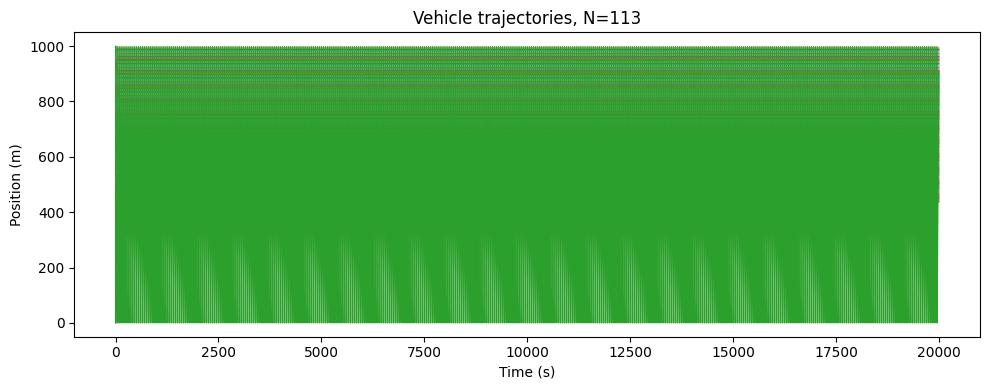

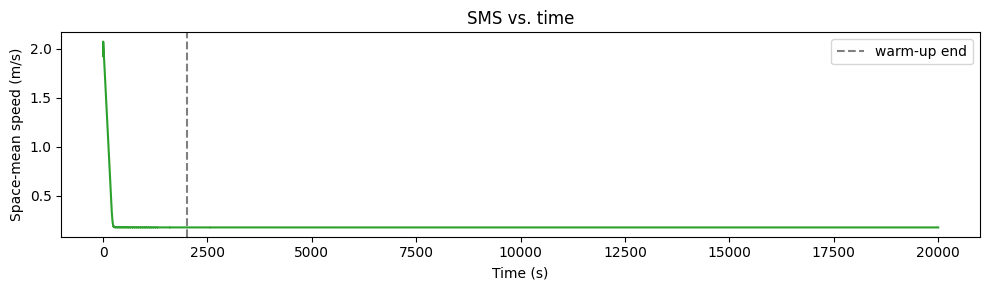

Steady SMS ≈ 0.18 m/s, density = 0.113 veh/m, flow ≈ 0.020 veh/s


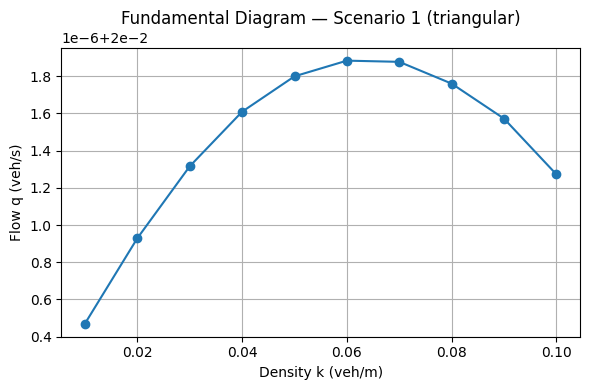

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Model parameters (gap τ=2 s, L=5 m, Δt=0.1 s) from the assignment
tau       = 2.0
L_vehicle = 5.0
dt        = 0.1
v_f       = 20.0

L_road   = 1000.0
T_total  =20000.0
warmup   = 2000.0

def simulate(N, T=T_total):
    n_steps = int(T / dt)
    x = np.linspace(0, L_road - L_vehicle, N)
    v = np.zeros(N)
    traj = np.zeros((n_steps, N))
    SMS  = np.zeros(n_steps)
    
    for t in range(n_steps):
        traj[t] = x.copy()
        # Compute gap to the leading vehicle (with wrap-around)
        x_next = np.roll(x, -1)
        gaps   = x_next - x - L_vehicle
        gaps[-1] += L_road
        # Clamp gaps to be at least zero
        gaps = np.maximum(gaps, 0.0)
        # Compute speed using Newell's car-following model
        v = np.minimum(gaps / tau, v_f)
        # Update positions using the computed speed (with periodic boundary)
        x = (x + v * dt) % L_road
        # Record the space-mean speed
        SMS[t] = v.mean()
    
    return traj, SMS

def main():
    # ——— Prompt for N0 and validate ———
    while True:
        try:
            N0 = int(input("Enter number of vehicles (1–120): "))
            if 1 <= N0 <= 120:
                break
            else:
                print("Please enter an integer between 1 and 120.")
        except ValueError:
            print("Invalid input; please enter an integer.")
    
    # ——— Run simulation for that N0 ———
    traj, SMS = simulate(N0)
    times = np.arange(len(SMS)) * dt

    # a) Plot Trajectories
    plt.figure(figsize=(10, 4))
    for i in range(N0):
        plt.plot(times, traj[:, i], lw=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(f'Vehicle trajectories, N={N0}')
    plt.tight_layout()
    plt.show()

    # b) Plot SMS vs. Time
    plt.figure(figsize=(10, 3))
    plt.plot(times, SMS, color='tab:green')
    plt.axvline(warmup, color='gray', ls='--', label='warm‑up end')
    plt.xlabel('Time (s)')
    plt.ylabel('Space‑mean speed (m/s)')
    plt.title('SMS vs. time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compute steady‑state SMS and flow
    warmup_steps = int(warmup / dt)
    steady_sms   = SMS[warmup_steps:].mean()
    density0     = N0 / L_road  # veh/m
    flow0        = density0 * steady_sms
    print(f"Steady SMS ≈ {steady_sms:.2f} m/s, density = {density0:.3f} veh/m, flow ≈ {flow0:.3f} veh/s")

    # ——— Fundamental Diagram Sweep (densities -> flows) ———
    densities = np.linspace(0.01, 0.1, 10)  # in veh/m
    flows      = []
    for k in densities:
        N = max(2, int(k * L_road))
        # Ensure we never exceed 120 vehicles
        N = min(N, 120)
        _, SMS_k = simulate(N)
        steady_sms_k = SMS_k[warmup_steps:].mean()
        flows.append(k * steady_sms_k)

    plt.figure(figsize=(6, 4))
    plt.plot(densities, flows, 'o-', color='tab:blue')
    plt.xlabel('Density k (veh/m)')
    plt.ylabel('Flow q (veh/s)')
    plt.title('Fundamental Diagram — Scenario 1 (triangular)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
